In [1]:
from matplotlib.dates import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import IchimokuLibrary
import pandas as pd
import arch.bootstrap as ab
import numpy as np

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
data = pd.read_csv("data2.csv")

In [3]:
returns = np.log(data["Close"] / data["Close"].shift(1)).dropna()

In [4]:
bs = ab.StationaryBootstrap(5, returns, seed=44)

In [5]:
IchimokuLibrary.sharpe_ratio(returns, "en_l_1","ex_l_1", 9, 26,52).values

array([0.04088046, 0.09769606, 0.41844531])

In [6]:
# out = IchimokuLibrary.confidence_interval(bs,IchimokuLibrary.sharpe_ratio,10,20,30,("ex_l_1","en_l_1"))[1]

In [7]:
# out

In [8]:
def trade(data, short, medium, long):
    data = data.cumsum()
    chikou = data.shift(medium) > data.iloc[-1]
    return chikou

In [9]:
trade(returns,9,26,52).sum()

np.int64(11)

In [10]:
def rolling_trade_series_1(data_series, short, medium, long):
    """
    Applies the trading condition in a rolling fashion, using only past data at each step.
    
    Args:
        data_series (pd.Series): Input time series data.
        short (int): Short-term period (unused here).
        medium (int): Medium-term shift period.
        long (int): Long-term period (unused here).
        
    Returns:
        pd.Series: Boolean Series where True indicates the condition was met historically.
    """
    chikou = pd.Series(index=data_series.index, dtype=bool)
    
    for i in range(len(data_series)):
        window = data_series.iloc[:i+1]  # Data up to current index
        cum_window = window.cumsum()
        
        if i >= medium:
            shifted_val = cum_window.shift(medium).iloc[i]
            last_val = cum_window.iloc[i]
            chikou.iloc[i] = shifted_val < last_val
        else:
            chikou.iloc[i] = False  # Not enough data to compute
    
    return chikou

# Example usage:
rolling_result_1 = rolling_trade_series_1(returns, short=9, medium=26, long=52)


In [39]:
test_data = IchimokuLibrary.apply_ichi(returns.cumsum())
# test_data["ex_l_5"] = IchimokuLibrary.ex_l_5(test_data)
test_trade = IchimokuLibrary.trade(returns, "en_l_123", "ex_l_5", 9, 26, 52)
test_trade.sum()

np.float64(-1.4609685400492858)

In [ ]:
test_data["en_l_123"] = IchimokuLibrary.en_l_123(test_data)
test_data["ex_l_5"] = IchimokuLibrary.ex_l_5(test_data)

mask_1 = (test_data["en_l_123"] == 1) & (test_data["en_l_123"].shift(1) == 0)
mask_2 = (test_data["ex_l_5"] == 1) & (test_data["ex_l_5"].shift(1) == 0)

entry_np = mask_1.to_numpy()
exit_np = mask_2.to_numpy()
n = len(entry_np)
state_np = np.zeros(n, dtype=bool)
current_state = 0

for i in range(n):
    state_np[i] = current_state
    if entry_np[i]:
        current_state = 1
    elif exit_np[i]:
        current_state = 0

pd.DataFrame([state_np, mask_1, mask_2]).T

,0,1,2
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
2510,True,False,False
2511,True,False,False
2512,True,False,False
2513,True,False,False


In [59]:
(returns.iloc[:n] * state_np).sum()
# sns.lineplot(returns.cumsum())

np.float64(-0.820336548999581)

In [57]:
IchimokuLibrary.trade(returns,"en_l_123","ex_l_5",9,26,52).sum()

np.float64(-1.4609685400492858)

<Axes: xlabel='None', ylabel='Close'>

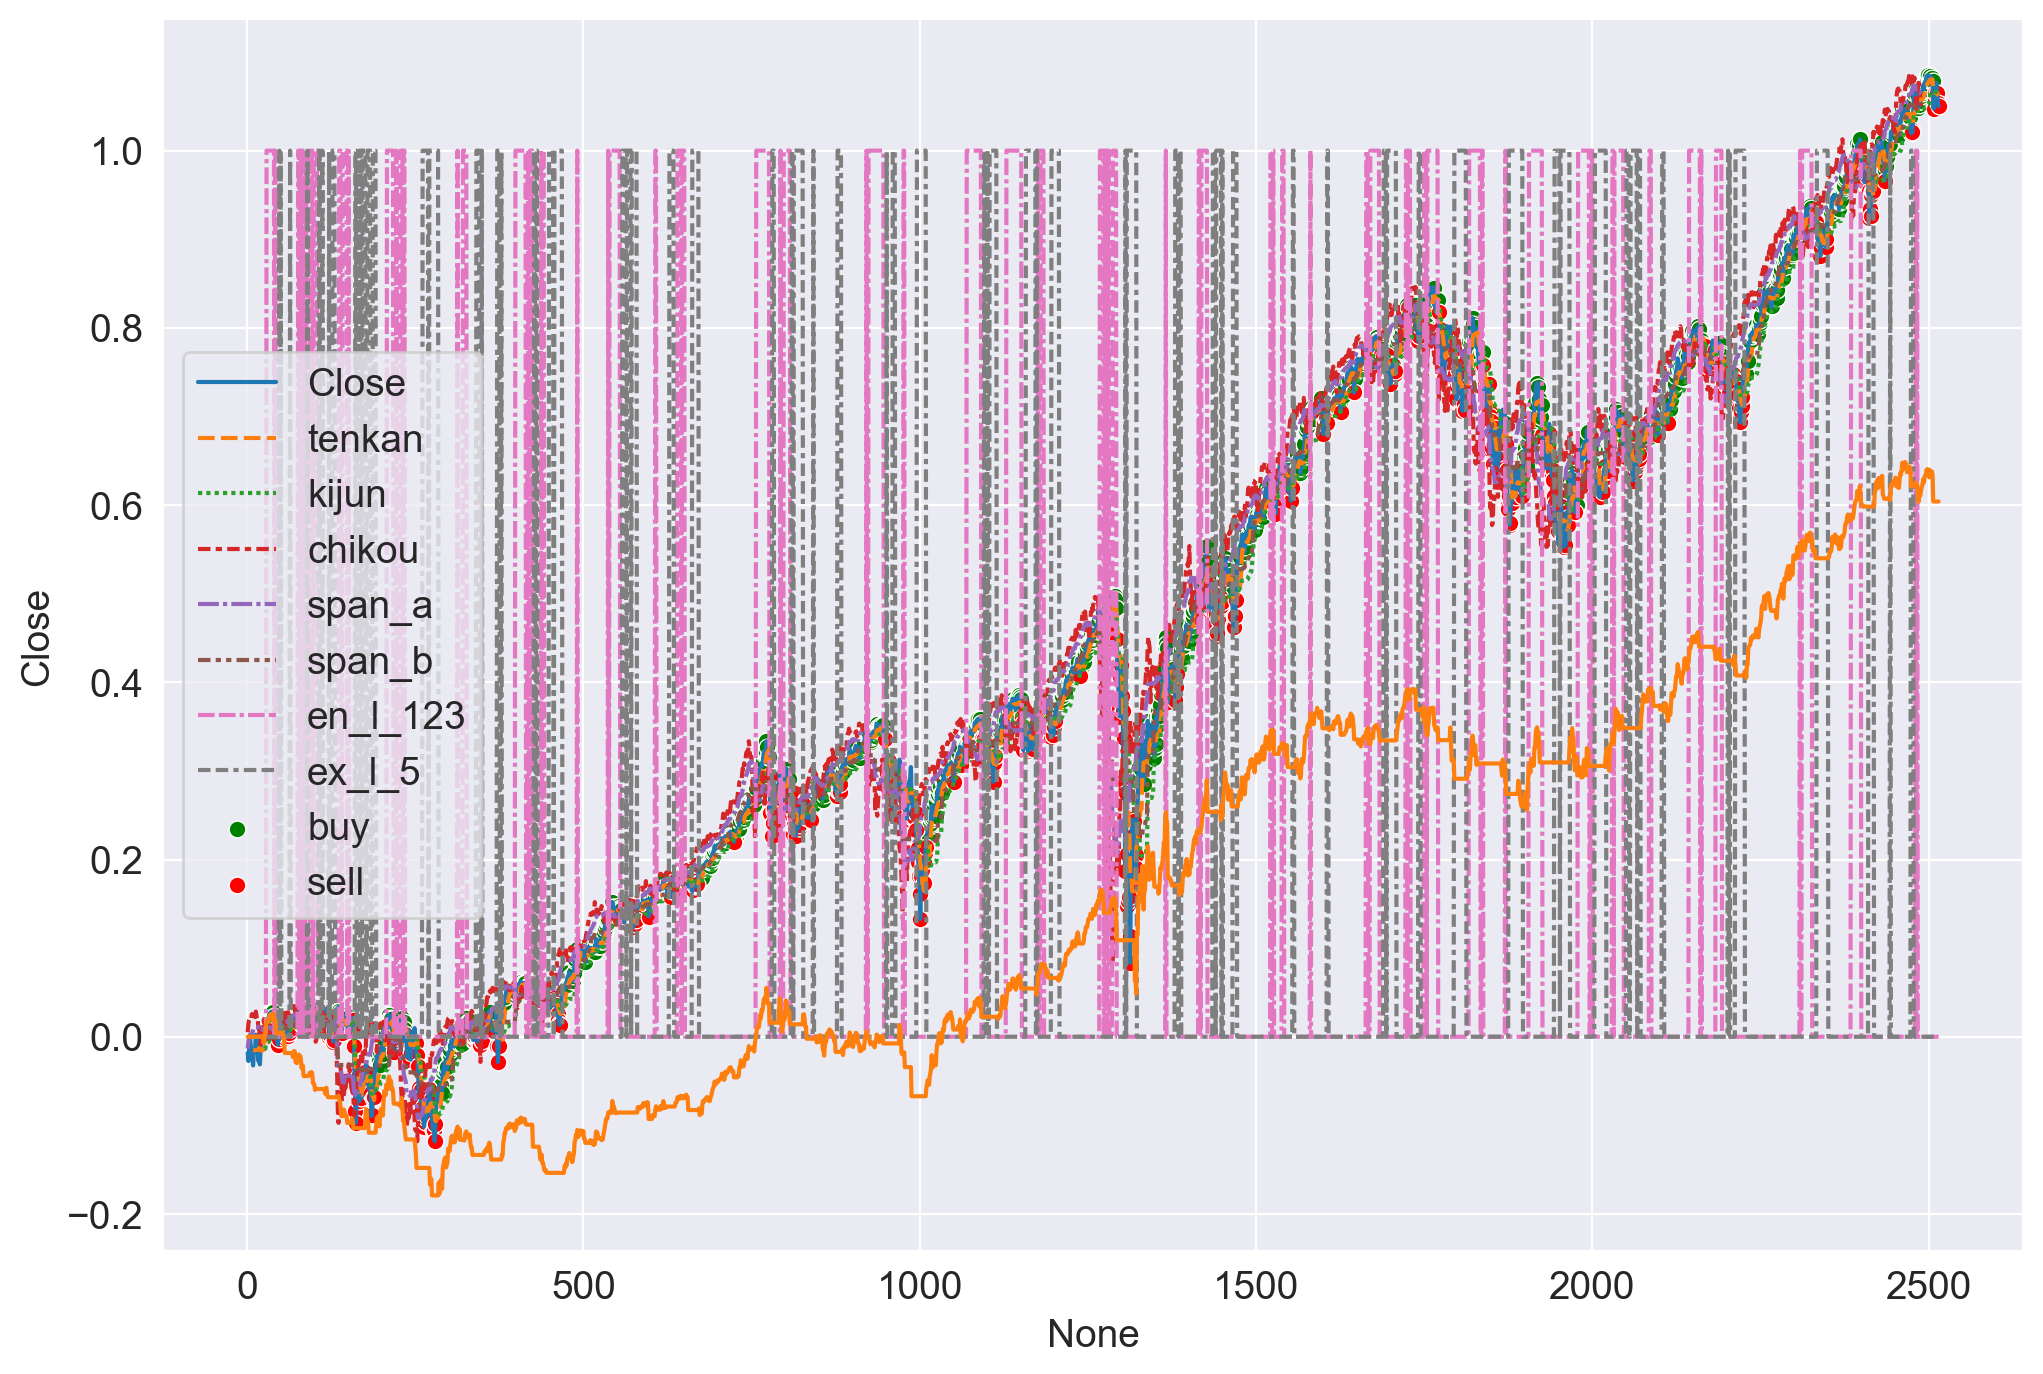

In [43]:
plt.figure(figsize=(12, 8),dpi=200)

# test_data = IchimokuLibrary.apply_ichi(returns[-180:].cumsum())

exits_1 = IchimokuLibrary.ex_l_1(test_data)
entry_1 = IchimokuLibrary.en_l_1(test_data)

position = 200
pos2= 1
sns.lineplot(test_data)
sns.lineplot(IchimokuLibrary.trade(returns,"en_l_1","ex_l_1",5,17,40).cumsum())

sns.scatterplot(test_data.loc[entry_1],y="Close",x=test_data.loc[entry_1].index,label="buy",c="green")
sns.scatterplot(test_data.loc[exits_1],y="Close",x=test_data.loc[exits_1].index,label="sell",c="red")   
# sns.scatterplot(test_data.loc[exits_2],y="Close",x=test_data.loc[exits_2].index)

In [44]:
IchimokuLibrary.apply_ichi(returns[:90].cumsum()).min(axis=0)

Close    -0.032356
tenkan   -0.015866
kijun    -0.013660
chikou   -0.008764
span_a   -0.013370
span_b   -0.002002
dtype: float64

In [45]:
IchimokuLibrary.l_3(IchimokuLibrary.apply_ichi(returns[:90].cumsum())) * IchimokuLibrary.l_2(IchimokuLibrary.apply_ichi(returns[:90].cumsum()))

1     False
2     False
3     False
4     False
5     False
      ...  
86    False
87    False
88    False
89    False
90    False
Length: 90, dtype: bool

In [46]:
np.max(IchimokuLibrary.apply_ichi(returns.cumsum())[["span_a","span_b"]],axis=1)

1      -0.013370
2      -0.005365
3      -0.000789
4       0.000009
5       0.000649
          ...   
2511         NaN
2512         NaN
2513         NaN
2514         NaN
2515         NaN
Length: 2515, dtype: float64

<Axes: xlabel='None', ylabel='None'>

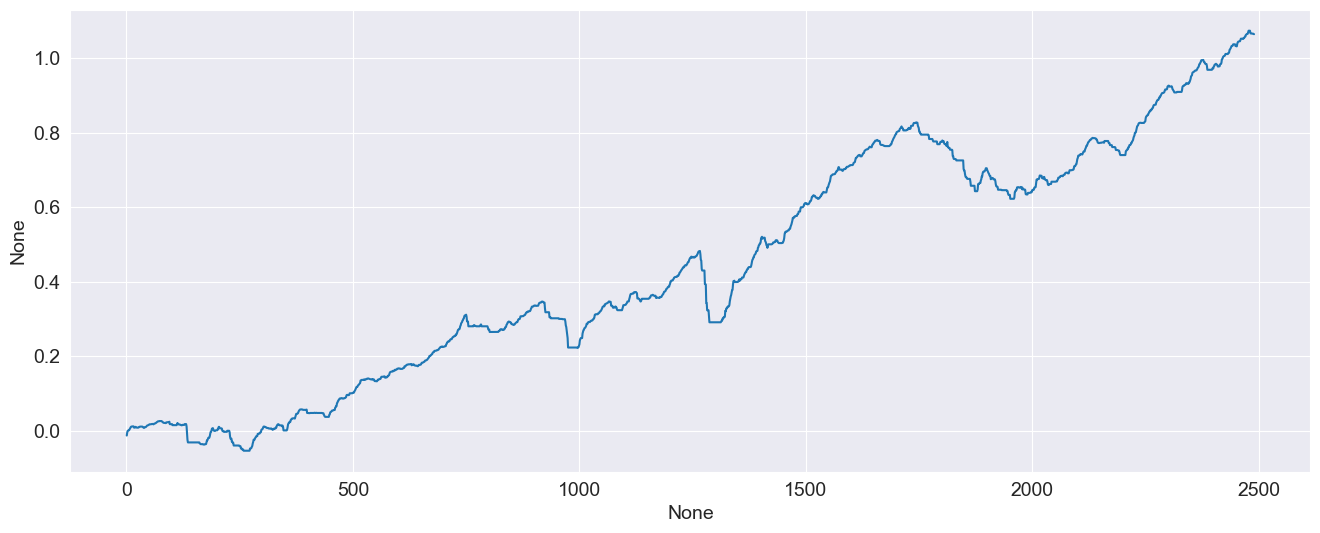

In [47]:
# IchimokuLibrary.trade(returns,"en_l_1","ex_l_1",9,26,52).plot()

sns.lineplot(y=np.max(IchimokuLibrary.apply_ichi(returns.cumsum())[["span_a", "span_b"]],axis=1),x=returns.index)

In [48]:
start_time = datetime.now() - relativedelta(seconds=-60)

current_time = ((start_time - datetime.now()).seconds / 30) * 15

In [49]:
str(current_time)

'29.5'

In [50]:
# Reproducability
import numpy as np

gen = np.random.default_rng(23456)
# Common seed used throughout
seed = gen.integers(0, 2**31 - 1)


In [51]:
import statsmodels.api as sm
from numpy.random import randn

t = 1000
factors = randn(t, 3)
beta = np.array([1, 0.5, 0.1])
e = randn(t)
y = factors.dot(beta)

In [52]:
# Measurement noise
bm_factors = factors + randn(t, 3)
# Fit using first half, predict second half
bm_beta = sm.OLS(y[:500], bm_factors[:500]).fit().params
# MSE loss
bm_losses = (y[500:] - bm_factors[500:].dot(bm_beta)) ** 2.0
# Number of models
k = 1000
model_factors = np.zeros((k, t, 3))
model_losses = np.zeros((500, k))
for i in range(k):
    # Add measurement noise
    model_factors[i] = factors + randn(1000, 3)
    # Compute regression parameters
    model_beta = sm.OLS(y[:500], model_factors[i, :500]).fit().params
    # Prediction and losses
    model_losses[:, i] = (y[500:] - model_factors[i, 500:].dot(model_beta)) ** 2.0


In [53]:
model_losses.shape

(500, 1000)

In [54]:
bm_losses.shape

(500,)

In [55]:
from arch.bootstrap import SPA

spa = SPA(bm_losses, model_losses, seed=seed)
spa.compute()
spa.pvalues


lower         0.811
consistent    0.988
upper         0.995
dtype: float64